In [1]:
using JuMP, ECOS, MathOptInterface, Utils, Plots, LinearAlgebra
using DifferentialEquations
include("./Rocket_Acceleration.jl")
include("./Quaternions.jl")

quatLog (generic function with 1 method)

In [2]:
t_coast = 3.45
dt = 0.1 # see LanderSolid.m, dt needs to be low. We need many degrees of freedom on u

N = floor(Int, t_coast / dt) + 1 
dt = t_coast / (N - 1)

wvc = 1e3 # wtr needs to be small, otherwise we get suboptimal solution, probably a local optima?

g = [0; 0; -9.80655]

r_0 = [20; -4; 30];	# position vector, m
v_0 = [4; -3; 0];		# velocity vector, m/s
r_N =[0; 0; 0];				# terminal position, m
v_N =[0; 0; 0];	# terminal velocity, m

In [3]:
# # Initial Guess

# t_coast = 0.0
# t_burn = 3.45
# tmp = [0; 0; - 2 * (r_0[3] + v_0[3] * t_burn) / t_burn^2] # [0.0, 0.0, -5.040957781978575]

# x = zeros(6, N)
# u = zeros(3, N)
# p = t_coast

# for k = 1:N
#     local t = (k - 1) / (N - 1) * t_burn
#     x[:, k] = [r_0 + t * v_0 + t^2 * tmp / 2; v_0 + tmp * t]
#     u[:, k] = -g + tmp # [0.0, 0.0, 4.765592218021425]
# end

Convex Optimisation Problem

In [ ]:
# #print(model)
# function build(x_prev, u_prev, dt, p_prev, t_burn, wvc, wtr)

#     model = Model(optimizer_with_attributes(ECOS.Optimizer, "verbose" => 0)); 

#     @variable(model, r[1:3, 1:N])
#     @variable(model, v[1:3, 1:N])

#     @variable(model, u[1:3, 1:N])

#     @variable(model, p)

#     @variable(model, virtual[1:6, 1:N])

#     @variable(model, delta_x[1:6, 1:N])
#     @variable(model, delta_u[1:3, 1:N])
#     @variable(model, delta_p)

#     t = @variable(model)
#     @constraint(model, [t; v[:, N] .- v_N] in SecondOrderCone()) # norm objective

#     # qtr = Inf
#     @variable(model, ηx[1:N])
#     @constraint(model, [k in 1:N], [ηx[k]; delta_x[:, k]] in MathOptInterface.NormInfinityCone(7))

#     @variable(model, ηu[1:N])
#     @constraint(model, [k in 1:N], [ηu[k]; delta_u[:, k]] in MathOptInterface.NormInfinityCone(4))

#     @variable(model, ηp)
#     @constraint(model, [ηp; delta_p] in MathOptInterface.NormInfinityCone(2))

#     @variable(model, P[1:N])
#     @constraint(model, [k in 1:N], [P[k]; virtual[:, k]] in MathOptInterface.NormOneCone(7))

#     time = collect(0:dt:t_burn)
#     @objective(model, Min, t + wtr*(trapz(ηx, time)+trapz(ηu, time)) + wtr * ηp + wvc*(trapz(P, time))  )

#     # @objective(model, Min, trapz(dot.(eachcol(r), eachcol(r)), collect(0:dt:t_coast)) ) # norm not supported in this fashion? cba to work out how

#     @constraint(model, p >= 0)

#     @constraint(model, r[:, 1] .== r_0 + p_prev * v_0 + p_prev^2 /2 * g + (v_0 + g * p_prev) * (p - p_prev))
#     @constraint(model, v[:, 1] .== v_0 + p_prev * g + g * (p - p_prev))

#     @constraint(model, r[3, N] == r_N[3])

#     @constraint(model, r[3, :] .>= 0)

#     # u1(k) = u[:, k] / norm(u[:, k])
#     # u2(k) = u[:, k + 1] / norm(u[:, k + 1])

#     # if slerpBool
#     #     @constraint(model, [k in 1:N-1], v[:, k + 1] .== v[:, k] + g * dt + dt / θ^2 * ((T1 - T2) * (u1 - u2) - θ * cot(θ) * (T1 * u1 + T2 * u2) + θ * csc(θ) *  (T2 * u1 + T1 * u2)) + virtual[4:6, k])
    
#     #     @constraint(model, [k in 1:N-1], r[:, k + 1] .== r[:, k] + v[:, k] * dt + g * dt^2 / 2 + dt^2 / θ^2 * (2 * T1 * u1 - T2 * (u1 + u2)) + dt^2 / θ^3 * cot(θ) * (-T1 * (-2 + θ^2) * u1 + 2 * T1 * u2 - 2 * T2 * (u1 + u2)) + dt^2 / θ^3 * csc(θ) * (-2 * T1 * u1 + T1 * (-2 + θ^2) * u2 + 2 * T2 * (u1 + u2)) + virtual[1:3, k])
#     # else
#         @constraint(model, [k in 1:N-1], v[:, k + 1] .== v[:, k] + (g + u[:, k] + g + u[:, k + 1]) / 2 * dt + virtual[4:6, k])
#         @constraint(model, [k in 1:N-1], r[:, k + 1] .== r[:, k] + dt / 2 * (v[:, k] + v[:, k + 1]) + dt^2 / 12 * (u[:, k] - u[:, k + 1]) + virtual[1:3, k])
#     # end
    
#     @constraint(model, [k in 1:N], [Acceleration(dt * (k - 1)); u[:, k]] in SecondOrderCone()) # @constraint(model, [k in 1:N], norm(u[:, k]) <= 10)

#     # Angular velocity constraint
#     # Non convex constraint is u(k + 1) dot u(k) >= cos(w_max) * |u(k)| * |u(k + 1)|

#     w_max = cos(deg2rad(45))

#     @constraint(model, [[0; 0; 1]' * u[:, 2] / (w_max * norm([0; 0; 1])); u[:, 2]] in SecondOrderCone())

#     @constraint(model, [[0; 0; 1]' * u[:, N - 1] / (w_max * norm([0; 0; 1])); u[:, N - 1]] in SecondOrderCone())

#     f0(k) = u_prev[:, k + 1]' * u_prev[:, k] - w_max * (norm(u_prev[:, k + 1]) * norm(u_prev[:, k]))
#     f_k(k) = u_prev[:, k + 1]' - w_max * norm(u_prev[:, k + 1]) * u_prev[:, k]' / norm(u_prev[:, k])
#     f_k1(k) = u_prev[:, k]' - w_max * norm(u_prev[:, k]) * u_prev[:, k + 1]' / norm(u_prev[:, k + 1])

#     @constraint(model, [k in 2:N-1], f0(k) + f_k(k) * (u[:, k] - u_prev[:, k]) + f_k1(k)  * (u[:, k + 1] - u_prev[:, k + 1]) >= 0)

#     @constraint(model, delta_x .== [r; v] .- x_prev) 
#     @constraint(model, delta_u .== u .- u_prev) 
#     @constraint(model, delta_p .== p - p_prev) 

#     return model
# end

In [13]:
# Initial Guess

t_coast = 0.0
t_burn = 3.45
tmp = [0; 0; - 2 * (r_0[3] + v_0[3] * t_burn) / t_burn^2] # [0.0, 0.0, -5.040957781978575]

x = zeros(6, N)
u = zeros(3, N)
p = t_coast

for k = 1:N
    local t = (k - 1) / (N - 1) * t_burn
    x[:, k] = [r_0 + t * v_0 + t^2 * tmp / 2; v_0 + tmp * t]
    u[:, k] = [0; 0; 1] # [0.0, 0.0, 4.765592218021425]
end

In [38]:
# u is normalised
function build(x_prev, u_prev, dt, p_prev, t_burn, wvc, wtr)

    model = Model(optimizer_with_attributes(ECOS.Optimizer, "verbose" => 0)); 

    @variable(model, r[1:3, 1:N])
    @variable(model, v[1:3, 1:N])

    @variable(model, u[1:3, 1:N])

    @variable(model, p)

    @variable(model, virtual[1:6, 1:N])

    @variable(model, delta_x[1:6, 1:N])
    @variable(model, delta_u[1:3, 1:N])
    @variable(model, delta_p)

    t = @variable(model)
    @constraint(model, [t; v[:, N] .- v_N] in SecondOrderCone()) # norm objective

    # qtr = Inf
    @variable(model, ηx[1:N])
    @constraint(model, [k in 1:N], [ηx[k]; delta_x[:, k]] in MathOptInterface.NormInfinityCone(7))

    @variable(model, ηu[1:N])
    @constraint(model, [k in 1:N], [ηu[k]; delta_u[:, k]] in MathOptInterface.NormInfinityCone(4))

    @variable(model, ηp)
    @constraint(model, [ηp; delta_p] in MathOptInterface.NormInfinityCone(2))

    @variable(model, P[1:N])
    @constraint(model, [k in 1:N], [P[k]; virtual[:, k]] in MathOptInterface.NormOneCone(7))

    time = collect(0:dt:t_burn)
    @objective(model, Min, t + wtr*(trapz(ηx, time)+trapz(ηu, time)) + wtr * ηp + wvc*(trapz(P, time))  )

    # @objective(model, Min, trapz(dot.(eachcol(r), eachcol(r)), collect(0:dt:t_coast)) ) # norm not supported in this fashion? cba to work out how

    @constraint(model, p >= 0)

    @constraint(model, r[:, 1] .== r_0 + p_prev * v_0 + p_prev^2 /2 * g + (v_0 + g * p_prev) * (p - p_prev))
    @constraint(model, v[:, 1] .== v_0 + p_prev * g + g * (p - p_prev))

    @constraint(model, r[3, N] == r_N[3])

    @constraint(model, r[3, :] .>= 0)

    Acc(k) = u[:, k] * Acceleration(dt * (k - 1))

    @constraint(model, [k in 1:N-1], v[:, k + 1] .== v[:, k] + (g + Acc(k) + g + Acc(k + 1)) / 2 * dt + virtual[4:6, k])
    @constraint(model, [k in 1:N-1], r[:, k + 1] .== r[:, k] + dt / 2 * (v[:, k] + v[:, k + 1]) + dt^2 / 12 * (Acc(k) - Acc(k + 1)) + virtual[1:3, k])
    
    @constraint(model, [k in 1:N], [1; u[:, k]] in SecondOrderCone()) # @constraint(model, [k in 1:N], norm(u[:, k]) <= 1)

    @constraint(model, u[:, 1] .== [0; 0; 1])
    @constraint(model, u[:, N] .== [0; 0; 1])

    # Angular velocity constraint
    # Non convex constraint is u(k + 1) dot u(k) >= cos(w_max) * |u(k)| * |u(k + 1)|

    w_max = cos(deg2rad(45))

    @constraint(model, [[0; 0; 1]' * u[:, 2] / (w_max * norm([0; 0; 1])); u[:, 2]] in SecondOrderCone())

    @constraint(model, [[0; 0; 1]' * u[:, N - 1] / (w_max * norm([0; 0; 1])); u[:, N - 1]] in SecondOrderCone())

    f0(k) = u_prev[:, k + 1]' * u_prev[:, k] - w_max * (norm(u_prev[:, k + 1]) * norm(u_prev[:, k]))
    f_k(k) = u_prev[:, k + 1]' - w_max * norm(u_prev[:, k + 1]) * u_prev[:, k]' / norm(u_prev[:, k])
    f_k1(k) = u_prev[:, k]' - w_max * norm(u_prev[:, k]) * u_prev[:, k + 1]' / norm(u_prev[:, k + 1])

    @constraint(model, [k in 2:N-1], f0(k) + f_k(k) * (u[:, k] - u_prev[:, k]) + f_k1(k)  * (u[:, k + 1] - u_prev[:, k + 1]) >= 0)

    @constraint(model, delta_x .== [r; v] .- x_prev) 
    @constraint(model, delta_u .== u .- u_prev) 
    @constraint(model, delta_p .== p - p_prev) 

    return model
end

build (generic function with 1 method)

In [39]:
println("Augmented cost               Cost                  Δu                    Coast time (s)             Equality Slack")

for i = 1:10
    local wtr = i < 5 ? 1e-3 : 1e1 # if we don't do this u[:, 3] bounces around in order to break ω_max constraint, and if wtr is too high we don't get to a good solution.
    local model = build(x, u, dt, p, t_burn, wvc, wtr)
    optimize!(model)
    # @show objective_value(model)
    # @show norm(JuMP.value.(model.obj_dict[:P]), Inf)
    # @show norm(JuMP.value.(model.obj_dict[:ηx]), Inf)

    local r = JuMP.value.(model.obj_dict[:r])
    local v = JuMP.value.(model.obj_dict[:v])  
    global x = [r; v]

    global u_prev = u
    global u = JuMP.value.(model.obj_dict[:u])

    global p = JuMP.value.(model.obj_dict[:p])

    local virtual = JuMP.value.(model.obj_dict[:virtual])

    println("$(objective_value(model))    $(norm(v[:, N] .- v_N))    $(norm(JuMP.value.(model.obj_dict[:ηu]), Inf))             $p                  $(norm(virtual))")
end

Augmented cost               Cost                  Δu                    Coast time (s)             Equality Slack


0.6496400148188702    0.6496343055318204    0.10936058276075988             1.3223172034623192                  6.011682774167031e-13


0.6496343051359331    0.6496343015512219    8.928801338272237e-7             1.3223171927801545                  5.014617088554678e-13
0.6496343024823147    0.6496342993469276    7.670699540285918e-7             1.3223171835380012                  4.676710754793275e-13
0.6496343002192797    0.6496342975398887    6.635790099658422e-7             1.322317175544642                  4.262366801035926e-13


0.6496342901014851    0.6496342976335067    1.0001477771581308e-9             1.322317175538323                  4.74787637897138e-12
0.6496342900776929    0.649634297725527    1.0002285766037408e-9             1.3223171755322456                  6.0219621880513025e-12
0.6496342900566182    0.6496342978157204    1.0001544498450266e-9             1.3223171755264673                  7.371767858095553e-12


0.6496342900360398    0.6496342979038372    1.0000727009854634e-9             1.3223171755211838                  9.396106882293953e-12
0.6496342900170193    0.6496342979905008    1.000013636315257e-9             1.3223171755160967                  1.1367037181874724e-11
0.6496342899969788    0.6496342980762074    1.0000813244465201e-9             1.3223171755109024                  1.2922317758744709e-11


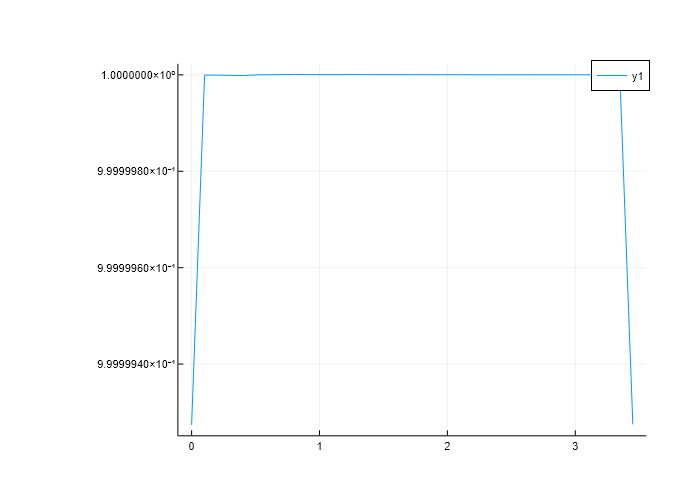

In [30]:
t = 0:dt:t_burn;

plotlyjs()

plot(t, norm.(eachcol(u)))
# plot(t, ThrottleLevel(norm.(eachcol(u)), Acceleration(t) ) )

In [31]:
u_normalised = deepcopy(u)

for k = 1:N
    if norm(u_normalised[:, k]) <= 1e-4
        u_normalised[:, k] = [0; 0; 1]
    end
end
ω_max = zeros(N - 1)
u_normalised =  u_normalised ./ norm.(eachcol(u_normalised))'

3×35 Matrix{Float64}:
 -0.00319291  -0.155733  -0.146061  …  -0.0516361  -0.0505292  -0.109361
  0.00239543   0.117377   0.110233      0.038477    0.0376424   0.0820704
  0.999992     0.980801   0.983115      0.997924    0.998013    0.990608

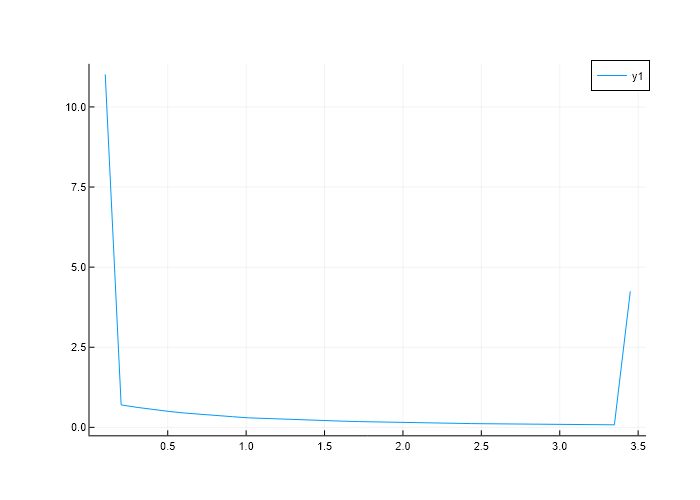

In [32]:
for k = 1:N-1
    ω_max[k] = acosd(u_normalised[:, k]' * u_normalised[:, k + 1])
end
plot(t[2:N], ω_max)

In [37]:
# Continuous version of u
function uc(u, u_normalised, dt, t, slerpBool, realAcceleration) 
    if t < 0 || t >= t_burn 
        return [0; 0; 0]
    else 
        tmp = Int(t ÷ dt) #floor(Int, t / dt)
        frac = (t % dt) / dt

        if slerpBool
            u_normalised = slerp(u_normalised[:, tmp + 1], u_normalised[:, tmp + 2], frac)
        else
            tmp = u[:, tmp + 1] + frac * (u[:, tmp + 2] - u[:, tmp + 1])
            u_normalised = tmp / norm(tmp)
        end

        if realAcceleration
            return u_normalised * Acceleration(t)
        else
            normu = norm(u[:, tmp + 1]) + frac * (norm(u[:, tmp + 2]) - norm(u[:, tmp + 1]))
            return u_normalised * normu
        end
    end
end

function f!(dx, x, p, t)
    dx[1:3] = x[4:6]
    Thrust = uc(u, u_normalised, dt, t, false, true) 
    dx[4:6] = g + Thrust
end

prob = ODEProblem(f!, x[:, 1], (0.0, t_burn))
sol = DifferentialEquations.solve(prob, reltol=1e-12, abstol=1e-12)

xc = sol(0:dt:t_burn).u
xmatrix = transpose(reduce(hcat, xc))
# plot(xmatrix[:, 1], xmatrix[:, 2], xmatrix[:, 3])
# # plot(sol)

println(norm(xmatrix - x', Inf))
println(norm(xmatrix - x'))

println("Cost: $(norm(xmatrix[end, 4:6] - v_N))")

0.2483421143625243
0.5505184643129497
Cost: 0.40026728927553273


In [34]:
# # Same as when slerpBool = true, realAcceleration = false

# r = zeros(3, N)
# v = zeros(3, N)

# r[:, 1] = x[1:3, 1]
# v[:, 1] = x[4:6, 1]

# Δt = t_coast / (N - 1)

# for k = 1:N-1
#     θ = acos(u_normalised[:, k]' * u_normalised[:, k + 1]) 
#     u1 = u_normalised[:, k]
#     u2 = u_normalised[:, k + 1]
#     T1 = norm(u[:, k])
#     T2 = norm(u[:, k + 1])

#     # Check mathematica notebook
#     v[:, k + 1] = v[:, k] + g * dt + dt / θ^2 * ((T1 - T2) * (u1 - u2) - θ * cot(θ) * (T1 * u1 + T2 * u2) + θ * csc(θ) *  (T2 * u1 + T1 * u2))
    
#     r[:, k + 1] = r[:, k] + v[:, k] * dt + g * dt^2 / 2 + dt^2 / θ^2 * (2 * T1 * u1 - T2 * (u1 + u2)) + dt^2 / θ^3 * cot(θ) * (-T1 * (-2 + θ^2) * u1 + 2 * T1 * u2 - 2 * T2 * (u1 + u2)) + dt^2 / θ^3 * csc(θ) * (-2 * T1 * u1 + T1 * (-2 + θ^2) * u2 + 2 * T2 * (u1 + u2))
# end
# x_slerp_exact = [r; v];

# println(norm(x_slerp_exact - x, Inf))
# println(norm(x_slerp_exact - x))

# println("Cost with slerp: $(norm(x_slerp_exact[4:6, end] - v_N))")

75.76935953337063
257.00286701404326
Cost with slerp: 43.618502702219224
